# Test Your Algorithm

## Instructions
1. From the **Pulse Rate Algorithm** Notebook you can do one of the following:
   - Copy over all the **Code** section to the following Code block.
   - Download as a Python (`.py`) and copy the code to the following Code block.
2. In the bottom right, click the <span style="color:blue">Test Run</span> button. 

### Didn't Pass
If your code didn't pass the test, go back to the previous Concept or to your local setup and continue iterating on your algorithm and try to bring your training error down before testing again.

### Pass
If your code passes the test, complete the following! You **must** include a screenshot of your code and the Test being **Passed**. Here is what the starter filler code looks like when the test is run and should be similar. A passed test will include in the notebook a green outline plus a box with **Test passed:** and in the Results bar at the bottom the progress bar will be at 100% plus a checkmark with **All cells passed**.
![Example](example.png)

1. Take a screenshot of your code passing the test, make sure it is in the format `.png`. If not a `.png` image, you will have to edit the Markdown render the image after Step 3. Here is an example of what the `passed.png` would look like 
2. Upload the screenshot to the same folder or directory as this jupyter notebook.
3. Rename the screenshot to `passed.png` and it should show up below.
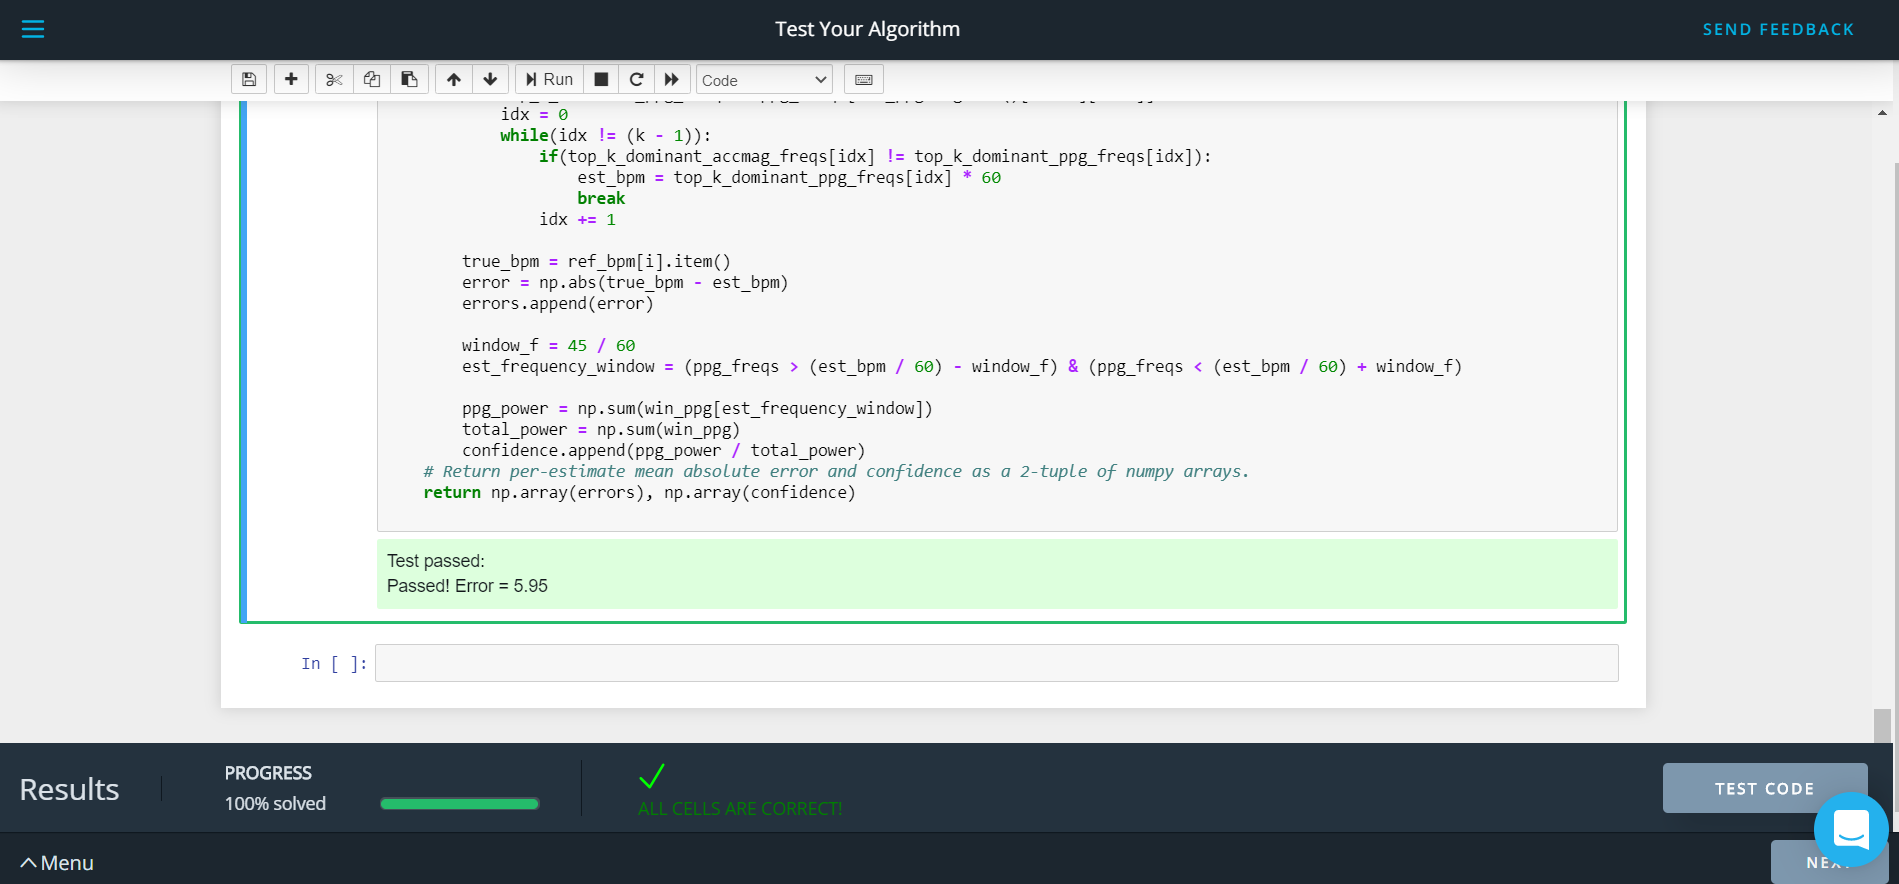
4. Download this jupyter notebook as a `.pdf` file. 
5. Continue to Part 2 of the Project. 

In [4]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt

fs = 125


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, fs=125):
    """Bandpass filter the signal between 0.667 Hz and 4 Hz."""
    b, a = butter(3, (2 / 3, 4), btype='bandpass', fs=fs)
    return filtfilt(b, a, signal)
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref_bpm  = sp.io.loadmat(ref_fl)['BPM0']
    
    # Caculates magnitude of accelerometer
    acc_mag = np.sqrt(np.sum(np.square(np.vstack((accx, accy, accz))), axis = 0)) 
    
    # Bandpass signal between 40-240BPM.
    filt_ppg = BandpassFilter(ppg)
    filt_accmag = BandpassFilter(acc_mag)
    
    # Calculates spectrogram of the filtered signal.
    # The dataset gives the BPM value in every 8-second time window and two successive time windows overlap by 6 seconds.
    ppg_spec, ppg_freqs, _, _ = plt.specgram(filt_ppg, Fs = fs, NFFT=8 * fs, noverlap=6 * fs)
    accmag_spec, accmag_freqs, _, _ = plt.specgram(filt_accmag, Fs = fs, NFFT=8 * fs, noverlap=6 * fs)
    
    errors, confidence = [], []
    est_bpm = 0
    for i in range(accmag_spec.shape[1]):
        win_accmag = accmag_spec[:, i]
        win_ppg = ppg_spec[:, i]
        
        # Finds out dominant frequency for PPG and Accelerometer Magnitude signal.
        dominant_accmag_freq = accmag_freqs[np.argmax(win_accmag)]
        dominant_ppg_freq = ppg_freqs[np.argmax(win_ppg)]
        
        # If both the dominant frequencies don't match, then take this as the estimated pulse rate from this window.
        if(dominant_accmag_freq != dominant_ppg_freq):
            est_bpm = dominant_ppg_freq * 60
            
        # If both of them match, then further check the next strongest PPG frequencies if there is another good candidate.
        else:
            
            # Finds top 3 next dominant PPG and Accelerometer Magnitude frequencies.
            k = 3
            top_k_dominant_accmag_freqs = accmag_freqs[win_accmag.argsort()[-k:-1][::-1]]
            top_k_dominant_ppg_freqs = ppg_freqs[win_ppg.argsort()[-k:-1][::-1]]
            idx = 0
            
            # Now loop till (k - 1) and check if frequencies match or not.
            while(idx != (k - 1)):
                
                # If both the dominant frequencies don't match, then take this as the estimated pulse rate from this window.
                if(top_k_dominant_accmag_freqs[idx] != top_k_dominant_ppg_freqs[idx]):
                    est_bpm = top_k_dominant_ppg_freqs[idx] * 60
                    break
                idx += 1
    
        # Computes pulse rate estimates and estimation confidence.
        true_bpm = ref_bpm[i].item()
        error = np.abs(true_bpm - est_bpm)
        errors.append(error)
        
        window_f = 40 / 60
        est_frequency_window = (ppg_freqs > (est_bpm / 60) - window_f) & (ppg_freqs < (est_bpm / 60) + window_f)
        
        # Confidence is estimated by summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.
        ppg_power = np.sum(win_ppg[est_frequency_window])
        total_power = np.sum(win_ppg)
        confidence.append(ppg_power / total_power)
        
    # Returns per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return np.array(errors), np.array(confidence)